# Model perfomance and Lazy Predict

So far we've tried a bunch of models without seeing a significant improvement. It shows the imbalance within the set. 

We could try a bunch of models 1 by 1 and review their results or we can get a quick overview of how multiple models will perform.

There are a few ways to do this.

1 way is using [Lazy Predict](https://github.com/shankarpandala/lazypredict.git). We originally tried this route but we found the processing to be really heavy and it killed the kernel. We tried using it with a subset of the models to reduce the load but it still ran really slow. Our little machines could not handle the truth.

2nd way was to import multiple classifiers from [scikitlearn](https://scikit-learn.org/stable/index.html) and use some of the visualization code from Lazy Predict to evaluate performance. This is the path documented below.

With this we can get a quick glance if there's a model that way outperforms ours.

In [21]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Import multiple classifiers to test
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

print("Libraries imported successfully!")


Libraries imported successfully!


In [22]:
# Load the cleaned data
with open('train_cleaned.pkl', 'rb') as f:
    train_df = pickle.load(f)

# Prepare features and target
X = train_df.drop('target', axis=1)
y = train_df['target']

print(f"Data loaded successfully!")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")


Data loaded successfully!
Shape of X: (595212, 34)
Shape of y: (595212,)
Target distribution:
target
0    0.9636
1    0.0364
Name: proportion, dtype: float64


In [23]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")


Training set size: 476169
Test set size: 119043
Training target distribution:
target
0    0.9636
1    0.0364
Name: proportion, dtype: float64
Test target distribution:
target
0    0.9636
1    0.0364
Name: proportion, dtype: float64


In [24]:
# Define classifiers to test (LazyPredict alternative)
classifiers = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, max_depth=5, eval_metric='logloss'),
    'MLPClassifier': MLPClassifier(max_iter=1000, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, max_depth=5, verbose=-1)
}

# Store results
results = []

print("Testing multiple classifiers...")
print("-" * 80)

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    try:
        # Train the model
        clf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else y_pred
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store results
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        })
        
        print(f"✓ {name} completed - ROC-AUC: {roc_auc:.4f}")
        
    except Exception as e:
        print(f"✗ {name} failed: {str(e)}")
        
print("\n" + "-" * 80)
print("All models tested!")


Testing multiple classifiers...
--------------------------------------------------------------------------------

Training Dummy Classifier...
✓ Dummy Classifier completed - ROC-AUC: 0.5000

Training Logistic Regression...
✓ Logistic Regression completed - ROC-AUC: 0.6203

Training Random Forest...
✓ Random Forest completed - ROC-AUC: 0.6306

Training Gradient Boosting...
✓ Gradient Boosting completed - ROC-AUC: 0.6387

Training AdaBoost...
✓ AdaBoost completed - ROC-AUC: 0.6356

Training Naive Bayes...
✓ Naive Bayes completed - ROC-AUC: 0.6102

Training K-Nearest Neighbors...
✓ K-Nearest Neighbors completed - ROC-AUC: 0.5182

Training XGBoost...
✓ XGBoost completed - ROC-AUC: 0.6276

Training MLPClassifier...
✓ MLPClassifier completed - ROC-AUC: 0.6283

Training LightGBM...
✓ LightGBM completed - ROC-AUC: 0.6387

--------------------------------------------------------------------------------
All models tested!


In [25]:
# Display results in a DataFrame (similar to LazyPredict output)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

# Format the output
pd.set_option('display.precision', 4)
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80 + "\n")
print(results_df.to_string(index=False))
print("\n" + "="*80)

# Display top 3 models
print("\nTop 3 Models by ROC-AUC:")
print("-" * 40)
for idx, row in results_df.head(3).iterrows():
    print(f"{idx+1}. {row['Model']}: {row['ROC-AUC']:.4f}")



MODEL COMPARISON RESULTS

              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
           LightGBM    0.9635     0.4000  0.0005    0.0009   0.6387
  Gradient Boosting    0.9635     0.3529  0.0014    0.0028   0.6387
           AdaBoost    0.9636     0.0000  0.0000    0.0000   0.6356
      Random Forest    0.9636     0.0000  0.0000    0.0000   0.6306
      MLPClassifier    0.9635     0.0000  0.0000    0.0000   0.6283
            XGBoost    0.9636     0.8000  0.0009    0.0018   0.6276
Logistic Regression    0.9636     0.0000  0.0000    0.0000   0.6203
        Naive Bayes    0.9036     0.0668  0.1268    0.0875   0.6102
K-Nearest Neighbors    0.9630     0.0694  0.0012    0.0023   0.5182
   Dummy Classifier    0.9636     0.0000  0.0000    0.0000   0.5000


Top 3 Models by ROC-AUC:
----------------------------------------
1. LightGBM: 0.6387
2. Gradient Boosting: 0.6387
3. AdaBoost: 0.6356


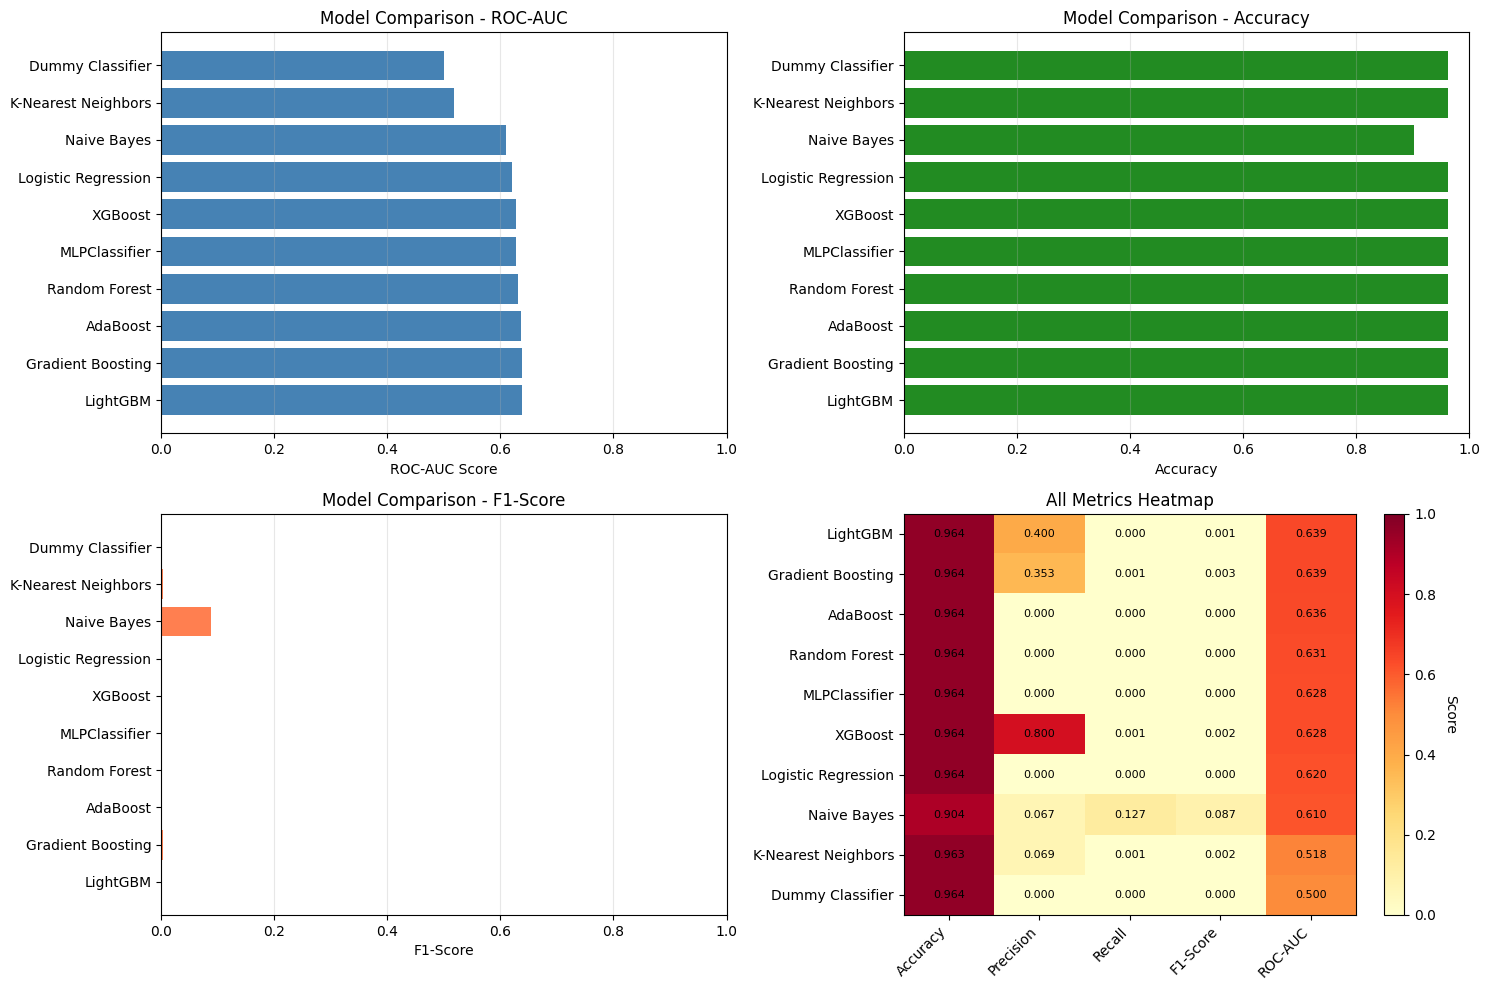

In [26]:
# Visualize model comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ROC-AUC comparison
axes[0, 0].barh(results_df['Model'], results_df['ROC-AUC'], color='steelblue')
axes[0, 0].set_xlabel('ROC-AUC Score')
axes[0, 0].set_title('Model Comparison - ROC-AUC')
axes[0, 0].set_xlim([0, 1])
axes[0, 0].grid(axis='x', alpha=0.3)

# Accuracy comparison
axes[0, 1].barh(results_df['Model'], results_df['Accuracy'], color='forestgreen')
axes[0, 1].set_xlabel('Accuracy')
axes[0, 1].set_title('Model Comparison - Accuracy')
axes[0, 1].set_xlim([0, 1])
axes[0, 1].grid(axis='x', alpha=0.3)

# F1-Score comparison
axes[1, 0].barh(results_df['Model'], results_df['F1-Score'], color='coral')
axes[1, 0].set_xlabel('F1-Score')
axes[1, 0].set_title('Model Comparison - F1-Score')
axes[1, 0].set_xlim([0, 1])
axes[1, 0].grid(axis='x', alpha=0.3)

# All metrics heatmap
metrics_df = results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
im = axes[1, 1].imshow(metrics_df.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
axes[1, 1].set_xticks(range(len(metrics_df.columns)))
axes[1, 1].set_xticklabels(metrics_df.columns, rotation=45, ha='right')
axes[1, 1].set_yticks(range(len(metrics_df.index)))
axes[1, 1].set_yticklabels(metrics_df.index)
axes[1, 1].set_title('All Metrics Heatmap')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('Score', rotation=270, labelpad=15)

# Add values to heatmap
for i in range(len(metrics_df.index)):
    for j in range(len(metrics_df.columns)):
        text = axes[1, 1].text(j, i, f'{metrics_df.values[i, j]:.3f}',
                              ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()
